In [2]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [ ]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    # todos get re-written
    todos: NotRequired[list[Todo]]
    # files get merged
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

In [ ]:
from typing import Annotated, NotRequired
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command

class SubAgentConfig(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_subagent_as_tool(tools: list[BaseTool], subagent_configs: list[SubAgentConfig], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagent_configs: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """

    # allows for name based lookup when assigning tool to sub agent if needed
    all_tools_by_name = {}
    for tool_ in tools:
      if not isinstance(tool_, BaseTool):
        # convert a non tool into tool
        tool_ = tool(tool_)
      all_tools_by_name[tool_.name] = tool_
    
    configured_agents = {}
    for agent_config in subagent_configs:
      if "tools" in agent_config:
        agent_tools = [all_tools_by_name[t_name] for t_name in agent_config["tools"]]
      else:
        # default to all tool
        agent_tools = tools
    
      configured_agents[agent_config["name"]] = create_react_agent(
        model=model, prompt=agent_config["prompt"], tools=agent_tools, state_schema=state_schema
      )

    
    configured_agents_description = [
        f"- {agent_config['name']}: {agent_config['description']}" for agent_config in subagent_configs
    ]

    TASK_DESCRIPTION_PREFIX=f"""
    Delegate a task to a specialized sub-agent with isolated context. Available agents for delegation are:
    {configured_agents_description}
    """

    @tool(description=TASK_DESCRIPTION_PREFIX)
    def task(
        task_description: str,
        subagent_name: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """

        if subagent_name not in configured_agents:
          return f"Error: invoked agent {subagent_name}, the only allowed agent are {[f'`{k}`' for k in configured_agents]}"
        
        subagent = configured_agents[subagent_name] 

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": task_description}]
        
        result = subagent.invoke(state)
        
        return Command(
          update={
              "files": result.get("files", {}),  # Merge any file changes
              "messages": [
                  # Sub-agent result becomes a ToolMessage in parent context
                  ToolMessage(
                      result["messages"][-1].content, tool_call_id=tool_call_id
                  )
              ],
          }
        )
        
        
        
    return task

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result

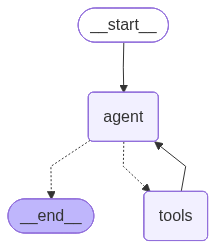

In [9]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)

# Create task tool to delegate tasks to sub-agents
task_tool = _create_subagent_as_tool(
    [web_search], [research_sub_agent], model, DeepAgentState
)

SUBAGENT_USAGE_INSTRUCTIONS = f"""You can delegate tasks to sub-agents.

<Task>
Your role is to coordinate research by delegating specific research tasks to sub-agents.
</Task>

<Available Tools>
1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents
   - description: Clear, specific research question or task
   - subagent_type: Type of agent to use (e.g., "research-agent")

**PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task** tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units} parallel agents per iteration.
</Available Tools>

<Hard Limits>
**Task Delegation Budgets** (Prevent excessive delegation):
- **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly beneficial or when you have multiple independent research directions based on the user's request.
- **Stop when adequate** - Don't over-research; stop when you have sufficient information
- **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found adequate sources
</Hard Limits>

<Scaling Rules>
**Simple fact-finding, lists, and rankings** can use a single sub-agent:
- *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in `findings_coffee_shops.md`

**Comparisons** can use a sub-agent for each element of the comparison:
- *Example*: "Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety" → Use 3 sub-agents
- Store findings in separate files: `findings_openai_safety.md`, `findings_anthropic_safety.md`, `findings_deepmind_safety.md`

**Multi-faceted research** can use parallel agents for different aspects:
- *Example*: "Research renewable energy: costs, environmental impact, and adoption rates" → Use 3 sub-agents
- Organize findings by aspect in separate files

**Important Reminders:**
- Each **task** call creates a dedicated research agent with isolated context
- Sub-agents can't see each other's work - provide complete standalone instructions
- Use clear, specific language - avoid acronyms or abbreviations in task descriptions
</Scaling Rules>"""

agent = create_react_agent(
    model,
    tools=[task_tool],
    prompt=SUBAGENT_USAGE_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [10]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "task_description": "Provide an overview of the Model Context Protocol (MCP), including its purpose, main     │
│ features, and current status as of 2024.",                                                                      │
│   "subagent_name": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_MRBbLqKytGgAYJoeuXW92QdX                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard developed by Anthropic to facilitate seamless integration  │
│ between AI models and external systems such as tools, databases, and other services. Here’s an overview based   │
│ on the latest information as of 2024:                                                                           │
│                                                                                                                 │
│ Purpose:                                                                                                        │
│ - MCP is designed to act as a standardized communication layer, enabling AI models to access, interact with,    │
│ and utilize data from a variety of external sources.                                                            │
│ - Its main goal is to simplify and unify the process of connecting AI assistants to external services, making   │
│ it easier for developers to build complex, context-aware AI applications.                                       │
│                                                                                                                 │
│ Main Features:                                                                                                  │
│ - Open Standard: MCP is openly specified, allowing broad adoption and interoperability across different         │
│ platforms and services.                                                                                         │
│ - Unified Language: It provides a consistent protocol for data exchange, reducing the complexity of integrating │
│ disparate systems with AI models.                                                                               │
│ - Extensibility: MCP is designed to be flexible, supporting a wide range of external tools, databases, and      │
│ APIs.                                                                                                           │
│ - Efficiency: By standardizing communication, MCP streamlines the process of fetching and utilizing external    │
│ data, improving the responsiveness and capabilities of AI assistants.                                           │
│                                                                                                                 │
│ Current Status (2024):                                                                                          │
│ - MCP is actively maintained and promoted by Anthropic, with growing adoption in the AI and developer           │
│ communities.                                                                                                    │
│ - It is being used to power integrations in various AI platforms, enabling richer and more context-aware        │
│ interactions.                                                                                                   │
│ - The protocol continues to evolve, with ongoing updates to support new use cases and integration scenarios.    │
│                                                                                                                 │
│ In summary, the Model Context Protocol (MCP) is a key enabler for advanced AI applications, providing a robust  │
│ and standardized way for AI models to interact with the broader digital ecosystem.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard developed by Anthropic to enable seamless integration      │
│ between AI models and external systems such as tools, databases, and services.                                  │
│                                                                                                                 │
│ Purpose:                                                                                                        │
│ - MCP provides a standardized communication layer, allowing AI models to access and interact with external data │
│ sources.                                                                                                        │
│ - It aims to simplify and unify how AI assistants connect to external services, making it easier for developers │
│ to build context-aware AI applications.                                                                         │
│                                                                                                                 │
│ Main Features:                                                                                                  │
│ - Open and interoperable: MCP is openly specified for broad adoption across platforms.                          │
│ - Unified protocol: It offers a consistent way to exchange data, reducing integration complexity.               │
│ - Extensible: Designed to support a wide range of tools, databases, and APIs.                                   │
│ - Efficient: Standardization streamlines data fetching and use, improving AI assistant capabilities.            │
│                                                                                                                 │
│ Current Status (2024):                                                                                          │
│ - MCP is actively maintained by Anthropic and is seeing growing adoption in the AI and developer communities.   │
│ - It powers integrations in various AI platforms, enabling richer, more context-aware interactions.             │
│ - The protocol is evolving, with updates to support new use cases and integrations.                             │
│                                                                                                                 │
│ In summary, MCP is a foundational protocol for advanced AI applications, enabling robust, standardized          │
│ connections between AI models and the digital ecosystem.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯